In [1]:
import os.path as osp
import os
import torch
from torch_geometric.data import DataLoader, Batch, Data
from torch_geometric.data import Data, InMemoryDataset, download_url, extract_zip
from torch_geometric.utils import sort_edge_index
from dig.xgraph.dataset import SynGraphDataset
from dig.xgraph.models import *
from dig.sslgraph.utils import Encoder

from bashaps import BAShapes
from downstream import MLP, EndtoEnd, train_MLP
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [2]:
dataset = BAShapes()
loader = DataLoader(dataset, 1)

In [3]:
encoder = Encoder(feat_dim=dataset[0].x.shape[1], hidden_dim=300, 
                  n_layers=3, gnn='gcn', node_level=True, graph_level=False)
encoder.load_state_dict(torch.load('ckpts_model/encoder_bashape.pth', map_location='cpu'))
mlp_model = MLP(num_layer = 2, emb_dim = 300, hidden_dim = 300, out_dim = 4)
mlp_model.load_state_dict(torch.load('ckpts_model/downstream_bashape.pth'))

<All keys matched successfully>

In [4]:
from tagexplainer import TAGExplainer, MLPExplainer
enc_explainer = TAGExplainer(encoder, embed_dim=300, device=device, explain_graph=False, 
                              grad_scale=0.1, coff_size=0.05, coff_ent=0.002, loss_type='JSE')

In [5]:
# enc_explainer.train_explainer_node(loader, batch_size=16, lr=5e-5, epochs=5)
# torch.save(enc_explainer.state_dict(), 'ckpts_explainer/explain_ba-shape.pt')

100%|██████████| 44/44 [00:09<00:00,  4.42it/s, loss=0.198, log=-0.3255, 0.7022, -20.9112, 0.0000] 


In [5]:
state_dict = torch.load('ckpts_explainer/explain_ba-shape.pt')
enc_explainer.load_state_dict(state_dict)

from dig.xgraph.evaluation import XCollector
loader = DataLoader(dataset, 1)
mlp_explainer = MLPExplainer(mlp_model, device)

x_collector = XCollector()
node_indices = torch.where(dataset[0].y != 0)[0]
subgraphs = []
mask_lst = []
for i, data in enumerate(loader):
    for j, node_idx in enumerate(node_indices):
        data.to(device)
        data.edge_attr = data.edge_label
        subgraph, masks, related_preds = \
            enc_explainer(data, mlp_explainer, node_idx=node_idx, top_k=5)
        fidelity = related_preds[0]['origin'] - related_preds[0]['maskout']
        subgraphs.append(subgraph)
        mask_lst.append(masks)

        print(f'explain graph {i} node {node_idx}'+' fidelity %.4f'%fidelity, end='\r')
        x_collector.collect_data(masks, related_preds)

fid, fid_std = x_collector.fidelity
spa, spa_std = x_collector.sparsity

print()
print(f'Fidelity: {fid:.4f} ±{fid_std:.4f}\n'
      f'Sparsity: {spa:.4f} ±{spa_std:.4f}')

explain graph 0 node 699 fidelity 0.99881
Fidelity: 0.7502 ±0.4290
Sparsity: 0.7638 ±0.1584


In [6]:
from torch_geometric.utils import to_networkx
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

In [7]:
auc_scores = []
for idx in range(len(node_indices)):
    subg = subgraphs[idx].cpu()
    masks = mask_lst[idx].cpu()
    gt = subgraphs[idx].edge_attr.cpu()
    # direct to undirect
    _, masks = sort_edge_index(subg.edge_index[:,subg.edge_index[0]<subg.edge_index[1]], 
                        masks[subg.edge_index[0]<subg.edge_index[1]])
    _, gt = sort_edge_index(subg.edge_index[:,subg.edge_index[0]<subg.edge_index[1]], 
                        gt[subg.edge_index[0]<subg.edge_index[1]])
    auc_scores.append(roc_auc_score(gt, masks))

np.array(auc_scores).mean()

0.9999547958585285

In [8]:
def visual(idx):
    subg = subgraphs[idx].cpu()
    masks = mask_lst[idx].cpu()
    _, masks = sort_edge_index(subg.edge_index[:,subg.edge_index[0]<subg.edge_index[1]], 
                    masks[subg.edge_index[0]<subg.edge_index[1]])
    subg.edge_index[:,subg.edge_index[0]>subg.edge_index[1]]
    colors = (masks >= masks.topk(6).values[-1]).int().tolist()
    G = to_networkx(subg, to_undirected=True)
    nx.draw(G, node_color = subg.y.tolist(), edge_color=np.array(['black', 'red'])[np.array(colors)])

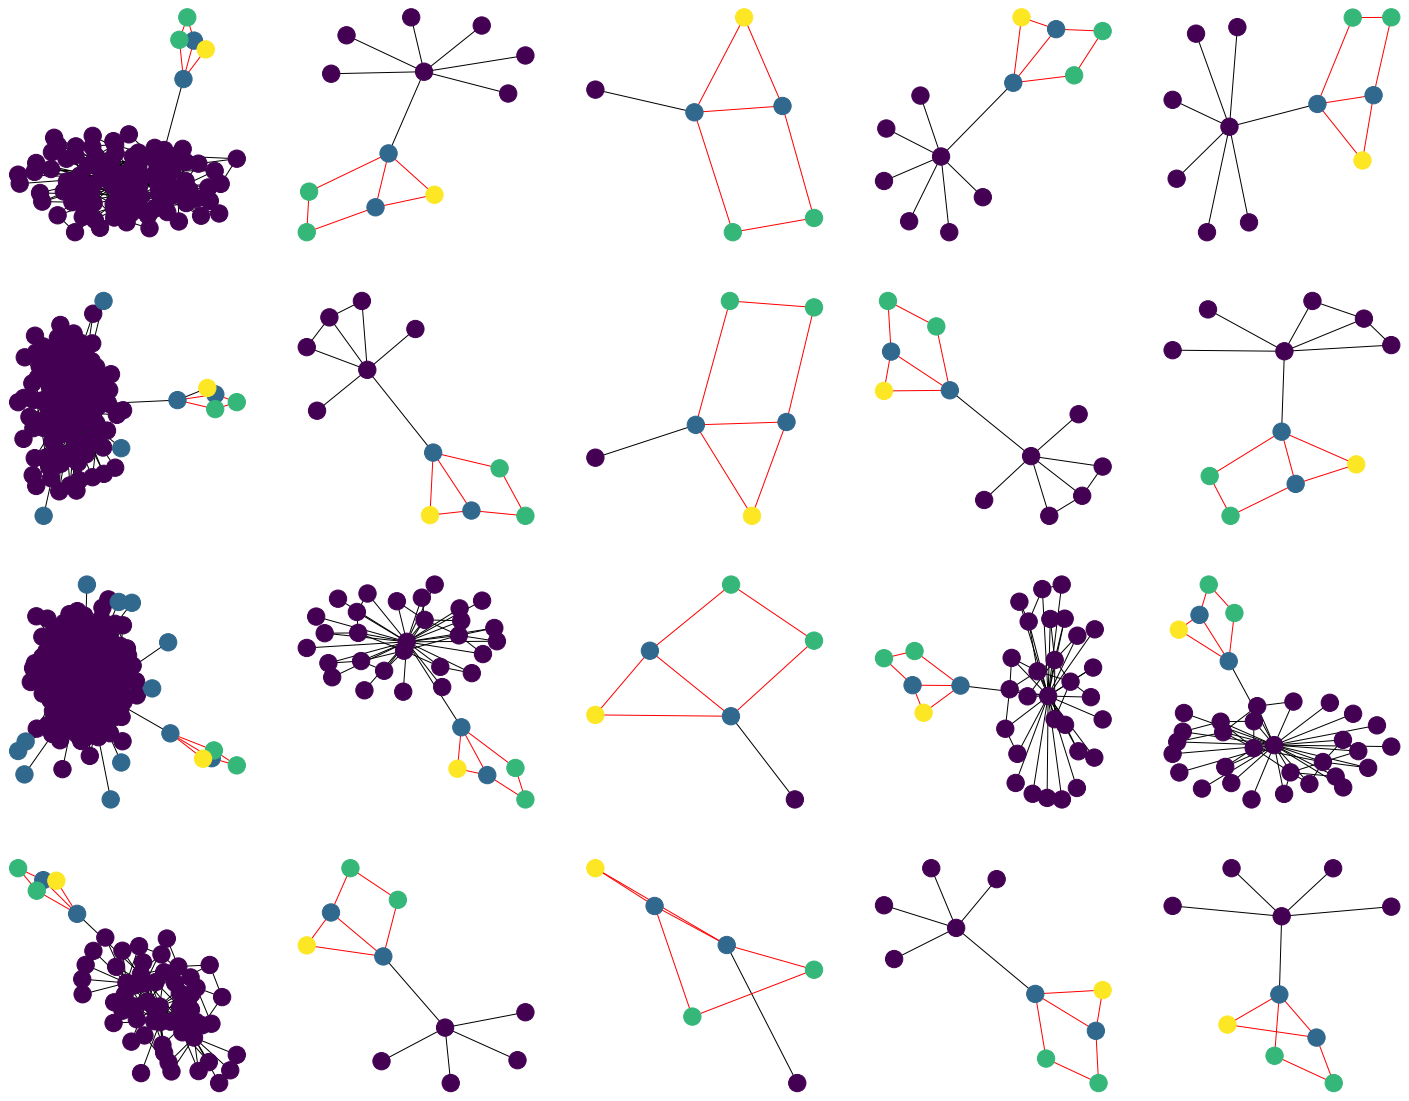

In [9]:
plt.figure(figsize=(25,20))
for i in range(20):
    plt.subplot(4, 5, i+1)
    visual(i)

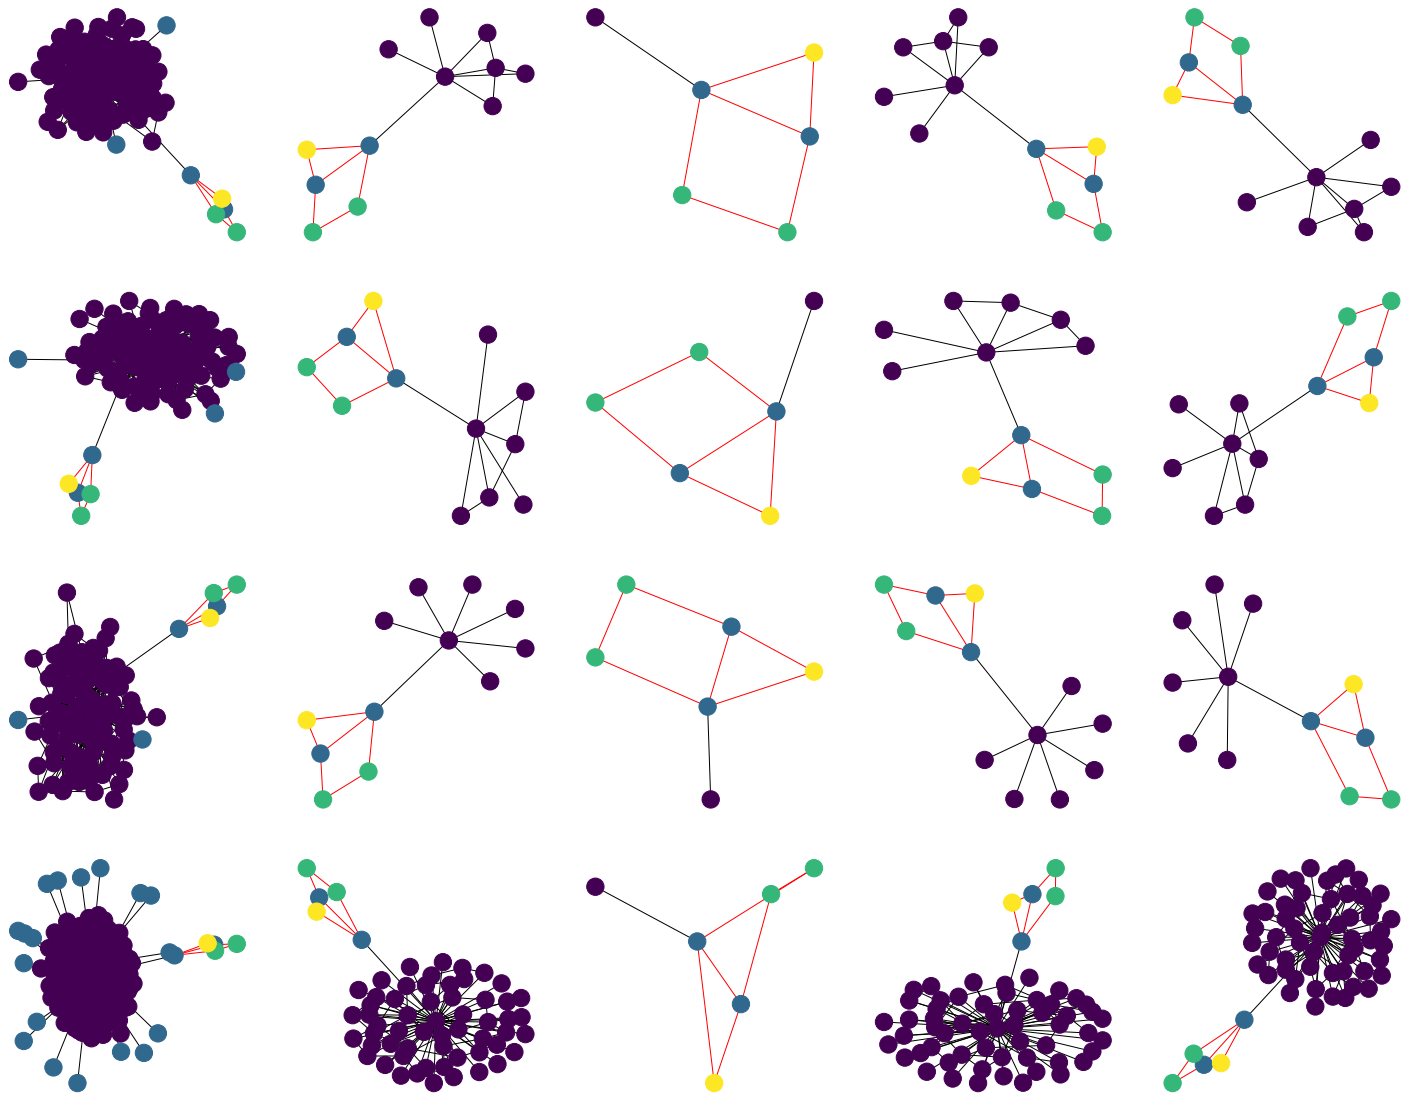

In [10]:
plt.figure(figsize=(25,20))
for i in range(20,40):
    plt.subplot(4, 5, i-19)
    visual(i)

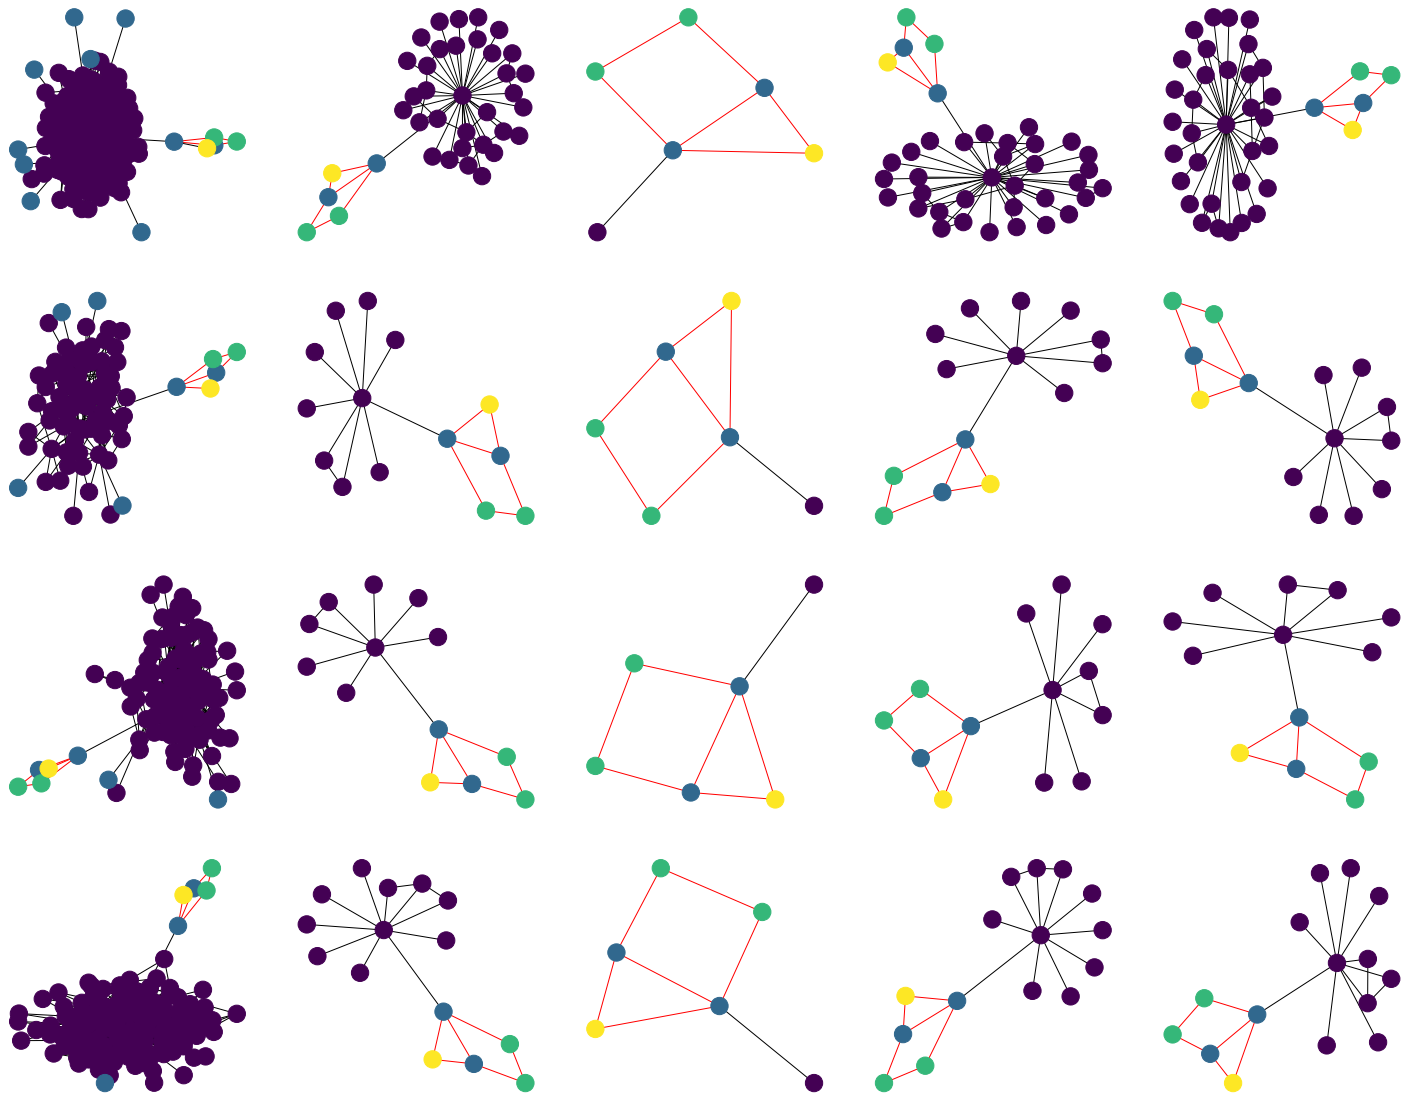

In [11]:
plt.figure(figsize=(25,20))
for i in range(40,60):
    plt.subplot(4, 5, i-39)
    visual(i)